In [1]:
import os
import numpy as np
import torch
import pyedflib
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F

# 고정 설정
sampling_rate = 256
segment_length = 30 * sampling_rate
label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"


In [2]:
def load_data_from_sn(sn_list):
    all_segments = []
    all_labels = []

    for sn in sn_list:
        base = f"SN{sn:03d}"
        ecg_path = os.path.join(root_dir, f"{base}.edf")
        label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")

        if not os.path.exists(ecg_path) or not os.path.exists(label_path):
            print(f"❌ 파일 없음: {base}")
            continue

        try:
            ecg_reader = pyedflib.EdfReader(ecg_path)
            ecg_signal = ecg_reader.readSignal(7)
        finally:
            ecg_reader._close()

        try:
            label_reader = pyedflib.EdfReader(label_path)
            annotations = label_reader.readAnnotations()
        finally:
            label_reader._close()

        onsets, durations, labels = annotations
        label_seq = []
        for i in range(len(labels)):
            label_str = labels[i].decode() if isinstance(labels[i], bytes) else labels[i]
            if label_str in label_map:
                label_index = label_map[label_str]
                num_segments = int(durations[i] // 30)
                label_seq.extend([label_index] * num_segments)

        max_segments = len(ecg_signal) // segment_length
        num_segments = min(len(label_seq), max_segments)

        for i in range(num_segments):
            start = i * segment_length
            end = start + segment_length
            segment = ecg_signal[start:end]

            # ✅ ECG 정규화 (Z-score 방식)
            segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-6)

            all_segments.append(segment)
            all_labels.append(label_seq[i])

    X = torch.tensor(np.array(all_segments), dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(all_labels, dtype=torch.long)
    return X, y


In [3]:
from collections import Counter
import numpy as np
import torch

def load_balanced_data_from_sn(sn_list):
    all_segments = []
    all_labels = []

    for sn in sn_list:
        try:
            X, y = load_data_from_sn([sn])  # SN 하나만 불러옴
        except Exception as e:
            print(f"❌ SN{sn:03d} 불러오기 실패: {e}")
            continue

        if len(y) == 0:
            print(f"⚠️ SN{sn:03d}: 라벨 없음 → 건너뜀")
            continue

        y_np = y.numpy()
        X_np = X.numpy()

        label_counts = Counter(y_np)
        if len(label_counts) < 2:
            print(f"⚠️ SN{sn:03d}: 라벨 다양성 부족 → 건너뜀")
            continue

        min_count = min(label_counts.values())
        indices = []

        for label in sorted(label_counts.keys()):
            label_indices = np.where(y_np == label)[0]
            if len(label_indices) < min_count:
                continue
            sampled = np.random.choice(label_indices, min_count, replace=False)
            indices.extend(sampled)

        if not indices:
            print(f"⚠️ SN{sn:03d}: 유효한 샘플 없음 → 건너뜀")
            continue

        np.random.shuffle(indices)
        all_segments.append(X_np[indices])
        all_labels.append(y_np[indices])

        print(f"✅ SN{sn:03d} 처리 완료: 클래스당 {min_count}개")

    if not all_segments:
        raise ValueError("⚠️ 유효한 데이터가 없습니다. SN 목록을 다시 확인하세요.")

    X_all = torch.tensor(np.concatenate(all_segments), dtype=torch.float32)
    y_all = torch.tensor(np.concatenate(all_labels), dtype=torch.long)
    return X_all, y_all


In [4]:
X_train, y_train = load_balanced_data_from_sn(list(range(1, 94)))  # SN001 ~ SN093
X_val, y_val = load_balanced_data_from_sn(list(range(94, 124)))   # SN094 ~ SN123
X_test, y_test = load_data_from_sn(list(range(124, 154)))

✅ SN001 처리 완료: 클래스당 23개


✅ SN002 처리 완료: 클래스당 82개


✅ SN003 처리 완료: 클래스당 150개


✅ SN004 처리 완료: 클래스당 64개


✅ SN005 처리 완료: 클래스당 127개


✅ SN006 처리 완료: 클래스당 65개


✅ SN007 처리 완료: 클래스당 67개


✅ SN008 처리 완료: 클래스당 39개


✅ SN009 처리 완료: 클래스당 91개


✅ SN010 처리 완료: 클래스당 101개


✅ SN011 처리 완료: 클래스당 37개


✅ SN012 처리 완료: 클래스당 184개


✅ SN013 처리 완료: 클래스당 65개
❌ 파일 없음: SN014
⚠️ SN014: 라벨 없음 → 건너뜀


✅ SN015 처리 완료: 클래스당 102개


✅ SN016 처리 완료: 클래스당 24개


✅ SN017 처리 완료: 클래스당 96개


✅ SN018 처리 완료: 클래스당 19개


✅ SN019 처리 완료: 클래스당 72개


✅ SN020 처리 완료: 클래스당 67개


✅ SN021 처리 완료: 클래스당 156개


✅ SN022 처리 완료: 클래스당 115개


✅ SN023 처리 완료: 클래스당 74개


✅ SN024 처리 완료: 클래스당 70개


✅ SN025 처리 완료: 클래스당 106개


✅ SN026 처리 완료: 클래스당 127개


✅ SN027 처리 완료: 클래스당 19개


✅ SN028 처리 완료: 클래스당 136개


✅ SN029 처리 완료: 클래스당 59개


✅ SN030 처리 완료: 클래스당 108개


✅ SN031 처리 완료: 클래스당 74개


✅ SN032 처리 완료: 클래스당 133개


✅ SN033 처리 완료: 클래스당 47개


✅ SN034 처리 완료: 클래스당 75개


✅ SN035 처리 완료: 클래스당 108개


✅ SN036 처리 완료: 클래스당 87개


✅ SN037 처리 완료: 클래스당 65개


✅ SN038 처리 완료: 클래스당 61개


✅ SN039 처리 완료: 클래스당 108개


✅ SN040 처리 완료: 클래스당 62개


✅ SN041 처리 완료: 클래스당 130개


✅ SN042 처리 완료: 클래스당 148개


✅ SN043 처리 완료: 클래스당 56개


✅ SN044 처리 완료: 클래스당 55개


✅ SN045 처리 완료: 클래스당 129개


✅ SN046 처리 완료: 클래스당 49개


✅ SN047 처리 완료: 클래스당 125개


✅ SN048 처리 완료: 클래스당 146개


✅ SN049 처리 완료: 클래스당 41개


✅ SN050 처리 완료: 클래스당 25개


✅ SN051 처리 완료: 클래스당 84개


✅ SN052 처리 완료: 클래스당 59개


✅ SN053 처리 완료: 클래스당 163개


✅ SN054 처리 완료: 클래스당 28개


✅ SN055 처리 완료: 클래스당 115개


✅ SN056 처리 완료: 클래스당 64개


✅ SN057 처리 완료: 클래스당 7개


✅ SN058 처리 완료: 클래스당 103개


✅ SN059 처리 완료: 클래스당 138개


✅ SN060 처리 완료: 클래스당 46개


✅ SN061 처리 완료: 클래스당 150개
✅ SN062 처리 완료: 클래스당 5개


✅ SN063 처리 완료: 클래스당 139개
❌ 파일 없음: SN064
⚠️ SN064: 라벨 없음 → 건너뜀


✅ SN065 처리 완료: 클래스당 65개


✅ SN066 처리 완료: 클래스당 88개


✅ SN067 처리 완료: 클래스당 123개


✅ SN068 처리 완료: 클래스당 116개


✅ SN069 처리 완료: 클래스당 69개


✅ SN070 처리 완료: 클래스당 35개


✅ SN071 처리 완료: 클래스당 16개


✅ SN072 처리 완료: 클래스당 115개


✅ SN073 처리 완료: 클래스당 39개


✅ SN074 처리 완료: 클래스당 37개


✅ SN075 처리 완료: 클래스당 186개


✅ SN076 처리 완료: 클래스당 56개


✅ SN077 처리 완료: 클래스당 85개


✅ SN078 처리 완료: 클래스당 55개


✅ SN079 처리 완료: 클래스당 61개


✅ SN080 처리 완료: 클래스당 28개


✅ SN081 처리 완료: 클래스당 2개


✅ SN082 처리 완료: 클래스당 37개


✅ SN083 처리 완료: 클래스당 136개


✅ SN084 처리 완료: 클래스당 27개


✅ SN085 처리 완료: 클래스당 111개


✅ SN086 처리 완료: 클래스당 110개


✅ SN087 처리 완료: 클래스당 34개


✅ SN088 처리 완료: 클래스당 125개


✅ SN089 처리 완료: 클래스당 85개


✅ SN090 처리 완료: 클래스당 76개


✅ SN091 처리 완료: 클래스당 40개


✅ SN092 처리 완료: 클래스당 93개


✅ SN093 처리 완료: 클래스당 71개


✅ SN094 처리 완료: 클래스당 79개


✅ SN095 처리 완료: 클래스당 50개


✅ SN096 처리 완료: 클래스당 55개


✅ SN097 처리 완료: 클래스당 46개


✅ SN098 처리 완료: 클래스당 80개


✅ SN099 처리 완료: 클래스당 56개


✅ SN100 처리 완료: 클래스당 81개


✅ SN101 처리 완료: 클래스당 120개


✅ SN102 처리 완료: 클래스당 36개


✅ SN103 처리 완료: 클래스당 70개


✅ SN104 처리 완료: 클래스당 104개


✅ SN105 처리 완료: 클래스당 34개


✅ SN106 처리 완료: 클래스당 53개


✅ SN107 처리 완료: 클래스당 77개


✅ SN108 처리 완료: 클래스당 50개


✅ SN109 처리 완료: 클래스당 48개


✅ SN110 처리 완료: 클래스당 96개


✅ SN111 처리 완료: 클래스당 135개


✅ SN112 처리 완료: 클래스당 83개


✅ SN113 처리 완료: 클래스당 85개


✅ SN114 처리 완료: 클래스당 73개


✅ SN115 처리 완료: 클래스당 98개


✅ SN116 처리 완료: 클래스당 43개


✅ SN117 처리 완료: 클래스당 108개


✅ SN118 처리 완료: 클래스당 114개


✅ SN119 처리 완료: 클래스당 89개


✅ SN120 처리 완료: 클래스당 29개


✅ SN121 처리 완료: 클래스당 61개


✅ SN122 처리 완료: 클래스당 66개


✅ SN123 처리 완료: 클래스당 98개


❌ 파일 없음: SN135


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import numpy as np

# 🔹 모델 정의
class ECGSleepCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(ECGSleepCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * 960, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [6]:
import torch, random, numpy as np
from torch.utils.data import DataLoader, TensorDataset

# 🔹 데이터로더 설정
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

# 🔹 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSleepCNN(num_classes=4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 🔹 학습 루프 
for epoch in range(50):  # 최대 50 epoch
    model.train()
    loss_sum, correct, total = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, pred = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    train_acc = 100 * correct / total

    # 🔹 검증 단계
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            val_total += yb.size(0)
            val_correct += (pred == yb).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    print(f"📘 Epoch {epoch+1} | Train Loss: {loss_sum:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")


📘 Epoch 1 | Train Loss: 1346.4418 | Train Acc: 25.11% | Val Loss: 1.3863 | Val Acc: 25.24%


📘 Epoch 2 | Train Loss: 1274.0815 | Train Acc: 25.24% | Val Loss: 1.3865 | Val Acc: 24.42%


📘 Epoch 3 | Train Loss: 1275.0743 | Train Acc: 25.18% | Val Loss: 1.3865 | Val Acc: 24.30%


📘 Epoch 4 | Train Loss: 1274.9147 | Train Acc: 25.05% | Val Loss: 1.3864 | Val Acc: 25.24%


📘 Epoch 5 | Train Loss: 1274.4631 | Train Acc: 24.73% | Val Loss: 1.3862 | Val Acc: 25.25%


📘 Epoch 6 | Train Loss: 1274.3632 | Train Acc: 24.76% | Val Loss: 1.3865 | Val Acc: 24.29%


📘 Epoch 7 | Train Loss: 1272.2935 | Train Acc: 25.11% | Val Loss: 1.3865 | Val Acc: 24.29%


📘 Epoch 8 | Train Loss: 1272.2003 | Train Acc: 25.01% | Val Loss: 1.3855 | Val Acc: 25.75%


📘 Epoch 9 | Train Loss: 1270.8215 | Train Acc: 25.20% | Val Loss: 1.4270 | Val Acc: 25.65%


📘 Epoch 10 | Train Loss: 1258.4676 | Train Acc: 27.15% | Val Loss: 1.4276 | Val Acc: 31.26%


📘 Epoch 11 | Train Loss: 1229.0466 | Train Acc: 30.98% | Val Loss: 1.3903 | Val Acc: 29.56%


📘 Epoch 12 | Train Loss: 1214.7813 | Train Acc: 32.42% | Val Loss: 1.4021 | Val Acc: 32.27%


📘 Epoch 13 | Train Loss: 1203.3479 | Train Acc: 33.25% | Val Loss: 1.4462 | Val Acc: 33.74%


📘 Epoch 14 | Train Loss: 1199.4348 | Train Acc: 33.58% | Val Loss: 1.3699 | Val Acc: 31.24%


📘 Epoch 15 | Train Loss: 1189.8785 | Train Acc: 34.21% | Val Loss: 1.4057 | Val Acc: 32.56%


📘 Epoch 16 | Train Loss: 1186.5495 | Train Acc: 34.59% | Val Loss: 1.4642 | Val Acc: 32.71%


📘 Epoch 17 | Train Loss: 1179.3287 | Train Acc: 34.94% | Val Loss: 1.4140 | Val Acc: 31.44%


📘 Epoch 18 | Train Loss: 1170.3747 | Train Acc: 35.60% | Val Loss: 1.4846 | Val Acc: 32.57%


📘 Epoch 19 | Train Loss: 1161.8260 | Train Acc: 36.00% | Val Loss: 1.4895 | Val Acc: 32.82%


📘 Epoch 20 | Train Loss: 1157.8153 | Train Acc: 36.31% | Val Loss: 1.4211 | Val Acc: 31.05%


📘 Epoch 21 | Train Loss: 1146.7811 | Train Acc: 36.89% | Val Loss: 1.4687 | Val Acc: 31.43%


📘 Epoch 22 | Train Loss: 1139.3320 | Train Acc: 37.04% | Val Loss: 1.5361 | Val Acc: 31.09%


📘 Epoch 23 | Train Loss: 1132.4345 | Train Acc: 37.51% | Val Loss: 1.5784 | Val Acc: 31.68%


📘 Epoch 24 | Train Loss: 1127.4329 | Train Acc: 37.63% | Val Loss: 1.6934 | Val Acc: 31.99%


📘 Epoch 25 | Train Loss: 1118.6301 | Train Acc: 37.96% | Val Loss: 1.8128 | Val Acc: 32.05%


📘 Epoch 26 | Train Loss: 1114.2318 | Train Acc: 38.50% | Val Loss: 1.6555 | Val Acc: 32.36%


📘 Epoch 27 | Train Loss: 1109.4441 | Train Acc: 38.12% | Val Loss: 1.8798 | Val Acc: 31.14%


📘 Epoch 28 | Train Loss: 1101.1897 | Train Acc: 38.89% | Val Loss: 1.7856 | Val Acc: 32.56%


📘 Epoch 29 | Train Loss: 1102.0754 | Train Acc: 38.74% | Val Loss: 1.7424 | Val Acc: 31.38%


📘 Epoch 30 | Train Loss: 1096.9323 | Train Acc: 38.87% | Val Loss: 1.8557 | Val Acc: 31.64%


📘 Epoch 31 | Train Loss: 1095.3780 | Train Acc: 38.92% | Val Loss: 1.7748 | Val Acc: 31.11%


📘 Epoch 32 | Train Loss: 1091.8664 | Train Acc: 39.21% | Val Loss: 1.7989 | Val Acc: 30.60%


📘 Epoch 33 | Train Loss: 1084.6412 | Train Acc: 39.49% | Val Loss: 2.4176 | Val Acc: 32.05%


📘 Epoch 34 | Train Loss: 1084.5035 | Train Acc: 39.39% | Val Loss: 2.1121 | Val Acc: 32.20%


📘 Epoch 35 | Train Loss: 1082.1274 | Train Acc: 39.48% | Val Loss: 2.0145 | Val Acc: 31.06%


📘 Epoch 36 | Train Loss: 1078.5865 | Train Acc: 39.78% | Val Loss: 2.2371 | Val Acc: 31.88%


📘 Epoch 37 | Train Loss: 1078.6941 | Train Acc: 39.72% | Val Loss: 2.1020 | Val Acc: 31.90%


📘 Epoch 38 | Train Loss: 1076.6244 | Train Acc: 39.84% | Val Loss: 2.1519 | Val Acc: 31.38%


📘 Epoch 39 | Train Loss: 1073.8127 | Train Acc: 39.81% | Val Loss: 2.0553 | Val Acc: 32.37%


📘 Epoch 40 | Train Loss: 1074.5747 | Train Acc: 39.74% | Val Loss: 2.2365 | Val Acc: 31.57%


📘 Epoch 41 | Train Loss: 1072.5352 | Train Acc: 40.09% | Val Loss: 2.2669 | Val Acc: 31.88%


📘 Epoch 42 | Train Loss: 1070.3024 | Train Acc: 40.42% | Val Loss: 2.1511 | Val Acc: 31.28%


📘 Epoch 43 | Train Loss: 1068.7958 | Train Acc: 40.33% | Val Loss: 2.2316 | Val Acc: 31.88%


📘 Epoch 44 | Train Loss: 1065.8485 | Train Acc: 40.31% | Val Loss: 2.1428 | Val Acc: 31.45%


📘 Epoch 45 | Train Loss: 1064.9642 | Train Acc: 40.43% | Val Loss: 2.0427 | Val Acc: 30.98%


📘 Epoch 46 | Train Loss: 1066.6099 | Train Acc: 40.27% | Val Loss: 2.4764 | Val Acc: 31.64%


📘 Epoch 47 | Train Loss: 1064.1796 | Train Acc: 40.59% | Val Loss: 2.3903 | Val Acc: 32.18%


📘 Epoch 48 | Train Loss: 1062.8624 | Train Acc: 40.35% | Val Loss: 2.0863 | Val Acc: 31.22%


📘 Epoch 49 | Train Loss: 1067.2652 | Train Acc: 40.36% | Val Loss: 2.2427 | Val Acc: 31.70%


📘 Epoch 50 | Train Loss: 1057.9141 | Train Acc: 41.02% | Val Loss: 2.4639 | Val Acc: 31.70%


In [7]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for i in range(0, len(X_test), 32):
        xb = X_test[i:i+32].to(device)
        yb = y_test[i:i+32].to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


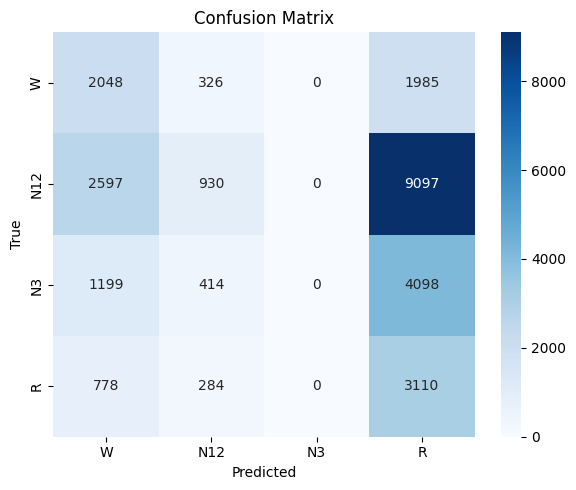

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.31      0.47      0.37      4359
         N12       0.48      0.07      0.13     12624
          N3       0.00      0.00      0.00      5711
           R       0.17      0.75      0.28      4172

    accuracy                           0.23     26866
   macro avg       0.24      0.32      0.19     26866
weighted avg       0.30      0.23      0.16     26866



/home/mhb0917/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhb0917/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhb0917/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
labels = ['W', 'N12', 'N3', 'R']

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification Report
print("📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))
